Вам нужно будет загрузить и оформить датасет котиков, собак  
https://www.kaggle.com/andrewmvd/dog-and-cat-detection   
Нужно будет произвести также аугментацию данных  
Затем обучить нейронную сеть на получившемся датасете используя модель с урока  
(* Усложненное задание) обучить faster-rcnn из статьи на датасете из енотов


In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

## Используемые функции

In [2]:
def generate_train_df (anno_path):
    annotations = [anno_path +'\\' + i for i in os.listdir(anno_path) ]
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = images_path + '/'+ root.find("./filename").text
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['depth'] = root.find("./size/depth").text
        anno['class'] = root.find("./object/name").text
        
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [3]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Ресайзим изображение и его обрамляющий прямоугольник и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    n_height,n_width ,*_ = im_resized.shape
    my_mask = create_mask(bb, im)
    Y_resized = cv2.resize(my_mask, (sz, sz))
    new_path = write_path + read_path[read_path.rfind('/'):]
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    bb_resize = mask_to_bb(Y_resized)
    return new_path, bb_resize ,n_width,n_height

In [4]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

In [5]:
def create_mask(bb, x):
    """Создаем маску для обрамляющего прямоугольника такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

In [6]:
def mask_to_bb(Y):
    """Конвертируем маску Y в обрамляющий прямоугольник, принимая 0 как фоновый ненулевой объект """
    rows,cols = np.nonzero(Y)
    if len(cols)<2: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([top_row,left_col,bottom_row, right_col], dtype=np.int)

In [7]:
# аугументация
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Случайное вырезание части картинки
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)


def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))


In [8]:
def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
#     imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

## Загрузим данные и приведем их к рабочему виду

In [9]:
images_path = r'D:\t2\images'
anno_path = r'D:\t2\annotations' 
train_path_resized = r'D:\t2\resaze' 

In [10]:
df_train = generate_train_df(anno_path)
df_train

,filename,width,height,depth,class,xmin,ymin,xmax,ymax
0,D:\t2\images/Cats_Test0.png,233,350,3,cat,83,29,197,142
1,D:\t2\images/Cats_Test1.png,500,500,3,dog,128,22,240,222
2,D:\t2\images/Cats_Test10.png,500,375,3,dog,157,56,264,116
3,D:\t2\images/Cats_Test100.png,500,375,3,cat,142,145,206,209
4,D:\t2\images/Cats_Test1000.png,335,500,3,cat,36,14,289,312
...,...,...,...,...,...,...,...,...,...
3681,D:\t2\images/Cats_Test995.png,500,375,3,dog,98,46,179,134
3682,D:\t2\images/Cats_Test996.png,500,335,3,cat,375,53,458,134
3683,D:\t2\images/Cats_Test997.png,500,333,3,cat,192,88,310,212
3684,D:\t2\images/Cats_Test998.png,375,500,3,cat,145,37,257,165


In [11]:
class_dict = {'cat': 0, 'dog': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])


In [12]:
df_train['bb'] = df_train.apply(lambda x: [x.ymin,x.xmin,x.ymax,x.xmax],axis = 1)

In [13]:
df_train

,filename,width,height,depth,class,xmin,ymin,xmax,ymax,bb
0,D:\t2\images/Cats_Test0.png,233,350,3,0,83,29,197,142,"[29, 83, 142, 197]"
1,D:\t2\images/Cats_Test1.png,500,500,3,1,128,22,240,222,"[22, 128, 222, 240]"
2,D:\t2\images/Cats_Test10.png,500,375,3,1,157,56,264,116,"[56, 157, 116, 264]"
3,D:\t2\images/Cats_Test100.png,500,375,3,0,142,145,206,209,"[145, 142, 209, 206]"
4,D:\t2\images/Cats_Test1000.png,335,500,3,0,36,14,289,312,"[14, 36, 312, 289]"
...,...,...,...,...,...,...,...,...,...,...
3681,D:\t2\images/Cats_Test995.png,500,375,3,1,98,46,179,134,"[46, 98, 134, 179]"
3682,D:\t2\images/Cats_Test996.png,500,335,3,0,375,53,458,134,"[53, 375, 134, 458]"
3683,D:\t2\images/Cats_Test997.png,500,333,3,0,192,88,310,212,"[88, 192, 212, 310]"
3684,D:\t2\images/Cats_Test998.png,375,500,3,0,145,37,257,165,"[37, 145, 165, 257]"


In [14]:
new_paths = []
new_bbs = []
new_width = []
new_height = []

for index, row in df_train.iterrows():
    new_path,new_bb,width,height = resize_image_bb(row['filename'], train_path_resized, row['bb'],300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    new_width.append(width)
    new_height.append(height)
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs
df_train['n_width'] = new_width
df_train['n_height'] = new_height

In [15]:
df_train

,filename,width,height,depth,class,xmin,ymin,xmax,ymax,bb,new_path,new_bb,n_width,n_height
0,D:\t2\images/Cats_Test0.png,233,350,3,0,83,29,197,142,"[29, 83, 142, 197]",D:\t2\resaze/Cats_Test0.png,"[24, 106, 121, 253]",300,300
1,D:\t2\images/Cats_Test1.png,500,500,3,1,128,22,240,222,"[22, 128, 222, 240]",D:\t2\resaze/Cats_Test1.png,"[13, 77, 132, 143]",300,300
2,D:\t2\images/Cats_Test10.png,500,375,3,1,157,56,264,116,"[56, 157, 116, 264]",D:\t2\resaze/Cats_Test10.png,"[44, 94, 92, 158]",300,300
3,D:\t2\images/Cats_Test100.png,500,375,3,0,142,145,206,209,"[145, 142, 209, 206]",D:\t2\resaze/Cats_Test100.png,"[116, 85, 167, 123]",300,300
4,D:\t2\images/Cats_Test1000.png,335,500,3,0,36,14,289,312,"[14, 36, 312, 289]",D:\t2\resaze/Cats_Test1000.png,"[8, 32, 186, 258]",300,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3681,D:\t2\images/Cats_Test995.png,500,375,3,1,98,46,179,134,"[46, 98, 134, 179]",D:\t2\resaze/Cats_Test995.png,"[36, 59, 107, 107]",300,300
3682,D:\t2\images/Cats_Test996.png,500,335,3,0,375,53,458,134,"[53, 375, 134, 458]",D:\t2\resaze/Cats_Test996.png,"[47, 225, 119, 274]",300,300
3683,D:\t2\images/Cats_Test997.png,500,333,3,0,192,88,310,212,"[88, 192, 212, 310]",D:\t2\resaze/Cats_Test997.png,"[79, 115, 190, 185]",300,300
3684,D:\t2\images/Cats_Test998.png,375,500,3,0,145,37,257,165,"[37, 145, 165, 257]",D:\t2\resaze/Cats_Test998.png,"[22, 116, 98, 205]",300,300


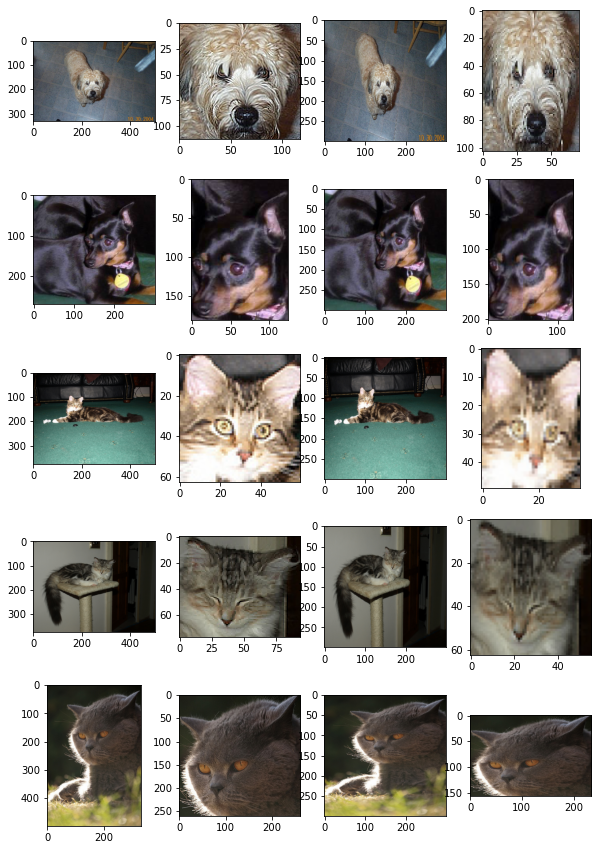

In [16]:
num = 5
rnd_num = np.random.randint(0,3000,(num))
fig, axes = plt.subplots(nrows=num, ncols=4, figsize=(10, 15))
for ind,i in enumerate(rnd_num):
    a = read_image(df_train.loc[i,'filename'])
    bb = df_train.loc[i,'bb']
    c=a[bb[0]:bb[2],bb[1]:bb[3]]
    axes[ind,0].imshow(a)
    axes[ind,1].imshow(c)
    a1 = read_image(df_train.loc[i,'new_path'])
    bb1 = df_train.loc[i,'new_bb']
    c1=a1[bb1[0]:bb1[2],bb1[1]:bb1[3]]
    axes[ind,2].imshow(a1)
    axes[ind,3].imshow(c1)
    

### Аугментация данных

D:\t2\resaze/Cats_Test1038.png


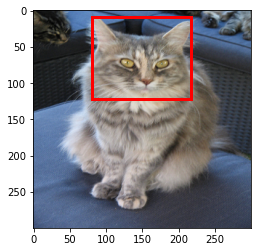

In [17]:
number = 45
im_path = df_train.loc[number,'new_path']
bb= df_train.loc[number,'new_bb']
im = cv2.imread(im_path)
print(im_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im,bb)

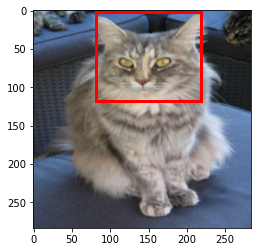

In [18]:
im, bb_ = transformsXY(im_path,bb,True )
show_corner_bb(im, bb_)

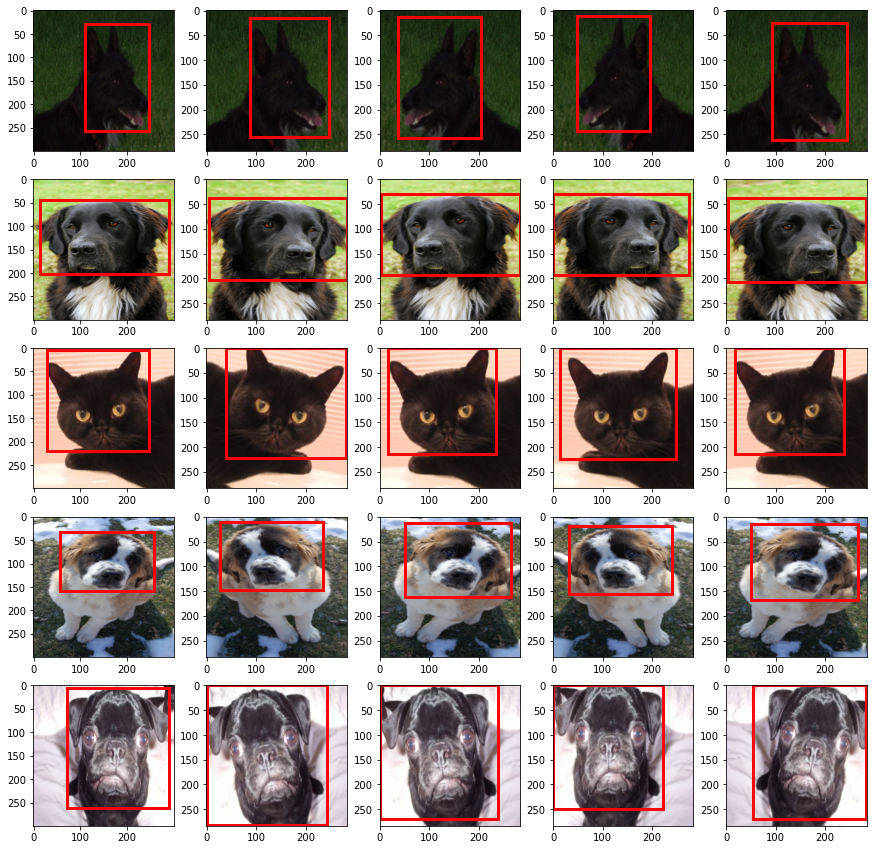

In [19]:
num = 5
it = 4
rnd_num = np.random.randint(0,3000,(num))

fig, axes = plt.subplots(nrows=num, ncols=5, figsize=(15, 15))
for ind,i in enumerate(rnd_num):
    im_path = df_train.loc[i,'new_path']
    a = read_image(im_path)
    bb_2 = df_train.loc[i,'new_bb']
    axes[ind,0].imshow(a)
    axes[ind,0].add_patch(create_corner_rect(bb_2))
    for j in range(it):
        c, bb_3 = transformsXY(im_path,bb_2,True )
        axes[ind,j+1].imshow(c)
        axes[ind,j+1].add_patch(create_corner_rect(bb_3))
        
        
        

все хорошо работает

### Датасет

In [20]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [21]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [22]:
train_ds = RoadDataset(paths = X_train['new_path'],bb = X_train['new_bb'] ,y = y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [23]:
len(train_ds),len(valid_ds)

(2948, 738)

## даталоадер

In [24]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

### Вектор нормализации

In [25]:
%%time
a=[]
for ind,row in df_train.iterrows():
    im= read_image(row.new_path)
    a.append(im)
a = np.array(a)  
mean = a.mean(axis=(0,1,2))
std = a.std(axis=(0,1,2))
imagenet_stats = np.array([mean,std])
    

Wall time: 23.9 s


In [26]:
imagenet_stats

array([[121.90201085, 113.61827397, 100.81414167],
       [ 67.66426912,  66.31938441,  68.36308689]])

## Модель

In [27]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 2))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [28]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)
epochs = 10

In [29]:
%%time
for i in range(epochs):
    
    model.train()
    total = 0
    sum_loss = 0
    C=1000
    
    for x, y_class, y_bb in train_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += loss.item()
    train_loss = sum_loss/total
    
    # Eval
    model.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        val_sum_loss += loss.item()
        val_total += batch
    val_loss = val_sum_loss/val_total
    val_acc = correct/val_total
    
    print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

train_loss 1.156 val_loss 0.972 val_acc 0.659
train_loss 0.858 val_loss 6.934 val_acc 0.659
train_loss 0.744 val_loss 11.442 val_acc 0.659
train_loss 0.721 val_loss 0.923 val_acc 0.659
train_loss 0.735 val_loss 0.768 val_acc 0.668
train_loss 0.727 val_loss 46.959 val_acc 0.659
train_loss 0.691 val_loss 4.801 val_acc 0.659
train_loss 0.663 val_loss 0.898 val_acc 0.346
train_loss 0.675 val_loss 3.978 val_acc 0.659
train_loss 0.633 val_loss 1.326 val_acc 0.341
Wall time: 10min 3s


In [46]:
for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = 0.0001

        
epochs = 5

In [48]:
%%time
for i in range(epochs):
    
    model.train()
    total = 0
    sum_loss = 0
    C=1000
    
    for x, y_class, y_bb in train_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += loss.item()
    train_loss = sum_loss/total
    
    # Eval
    model.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        val_sum_loss += loss.item()
        val_total += batch
    val_loss = val_sum_loss/val_total
    val_acc = correct/val_total
    
    print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

train_loss 0.084 val_loss 5.775 val_acc 0.341
train_loss 0.092 val_loss 1.485 val_acc 0.350
train_loss 0.085 val_loss 0.869 val_acc 0.696
train_loss 0.078 val_loss 2.037 val_acc 0.341
train_loss 0.079 val_loss 0.322 val_acc 0.915
Wall time: 5min 1s


## Тестирование

In [49]:
PATH_model = 'model.pth'
torch.save(model.state_dict(), PATH_model)

In [50]:
net = BB_model().eval()
net.load_state_dict(torch.load(PATH_model))

<All keys matched successfully>

In [51]:
classes = list(class_dict.keys())

In [52]:
images_in_bach = valid_dl.dataset.paths[:valid_dl.batch_size]

Определен dog


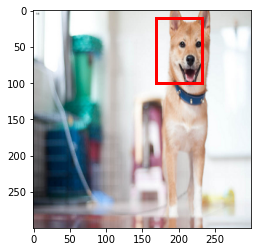

Определен dog


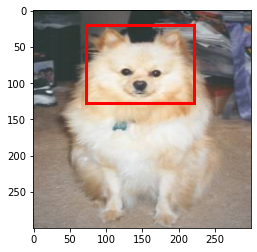

Определен dog


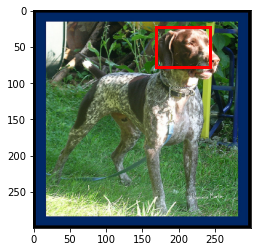

Определен cat


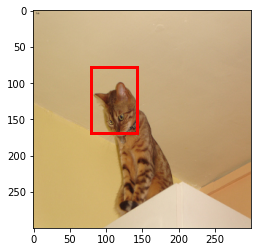

Определен cat


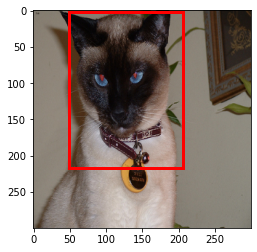

Определен cat


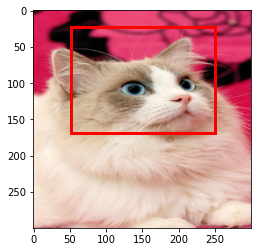

Определен dog


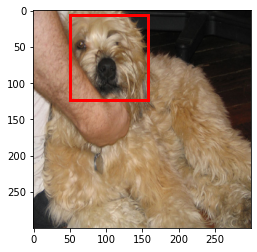

Определен cat


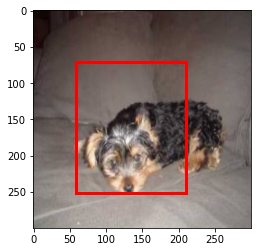

Определен cat


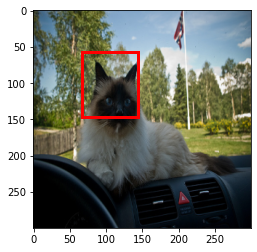

Определен cat


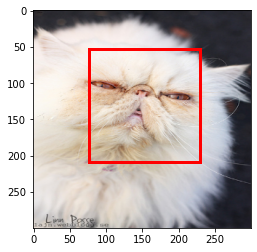

Определен cat


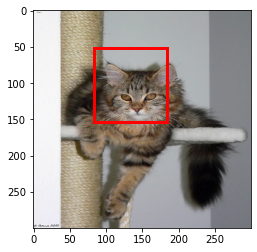

Определен cat


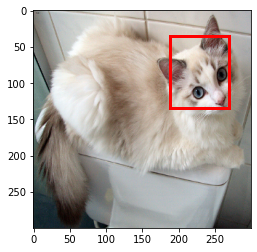

Определен dog


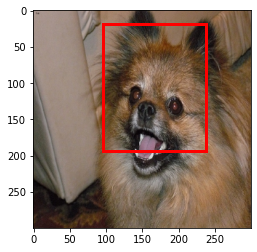

Определен dog


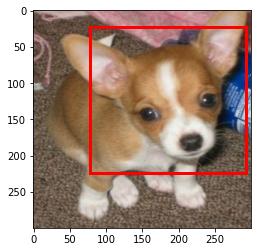

Определен cat


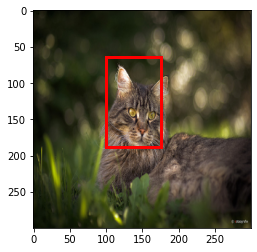

Определен cat


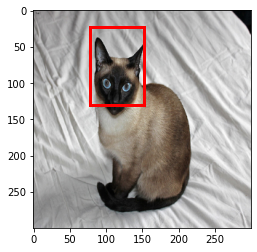

In [53]:
for x, y_class, y_bb  in valid_dl:
    x = x.float()
    out_class, out_bb = net(x)
    out_bb = out_bb.detach()
    _, pred_class = torch.max(out_class, 1)
    for ind,im_patch in enumerate(images_in_bach):
        print(f'Определен {classes[pred_class[ind]]}')      
        plt.imshow(read_image(im_patch))
        plt.gca().add_patch(create_corner_rect(out_bb[ind]))
        plt.show()
    break
    